In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pickle
from os import listdir
from os.path import isfile, join
import itertools
%matplotlib inline
    
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
ADV_GRAPH_LOC = '../logdir/data/graphs/adversaries/carlini_attacks_targeted1000'
GRAPH_LOC = '../logdir/data/graphs'
graphmls = [f for f in listdir(GRAPH_LOC) if isfile(join(GRAPH_LOC, f)) and int(f[2:f.find('.')]) < 300]
val_graphmls = [f for f in listdir(GRAPH_LOC) if isfile(join(GRAPH_LOC, f)) and int(f[2:f.find('.')]) >= 300 and int(f[2:f.find('.')]) <= 550]
test_graphmls = [f for f in listdir(GRAPH_LOC) if isfile(join(GRAPH_LOC, f)) and int(f[2:f.find('.')]) > 550]

adv_graphmls = [f for f in listdir(ADV_GRAPH_LOC) if isfile(join(ADV_GRAPH_LOC, f))][:450]

def get_matchings(x_list, y_list):
    ret = []
    for x in x_list:
        if y_list.isin([x]).any():
            ret.append(x)
    return ret

def get_list_matchings(x_list, y_list):
    ret = []
    for x in x_list:
        if x in y_list:
            ret.append(x)
    return ret

def average_sim(df):
    s = 0
    for col in df.columns:
        s += df[col].dropna().shape[0]
    return s/len(df.columns)

def rank_match_score(y, x):
    x.sort_values(ascending=False, inplace=True)
    x_size = x.shape[0]
    score = 0
    for i in range(x_size):
        if x.index[i] in y:
            score += x_size - i
    return score / (x_size)

def match_score(y,x):
    x_size = x.shape[0]
    score = 0
    y_size = len(y)
    for i in range(x_size):
        if x.index[i] in y:
            score += 1
    return float(score) / float(x_size)

def match(g, gs):
    best_score = 0
    best_match = None
    scores = {}
    for i in range(len(gs)):
        score = match_score(g, gs[i])
        scores[i] = score
        if score > best_score:
            best_score = score
            best_match = i
    return best_match, best_score, scores

def rank_match(g, gs):
    best_score = 0
    best_match = None
    scores = {}
    for i in range(len(gs)):
        score = rank_match_score(g, gs[i])
        scores[i] = score
        if score > best_score:
            best_score = score
            best_match = i
    return best_match, best_score, scores

In [3]:
tdf = []
asims = []
for i in range(10):
    df = []
    print("Step {}".format(i))
    for f in graphmls:
        if f[0] == str(i):
            print(f)
            col = {}
            g = nx.read_graphml(join(GRAPH_LOC, f))
            for node in g.nodes():
                if node[len(node)-1] == '3':
                    g.remove_node(node)
            df.append(g.nodes())
    df = pd.DataFrame(df, index=range(len(df))).transpose()
    
    print(df.shape)
    
    mdf = None
    r = list(df.columns)
    for perm in itertools.combinations(r, 2):
        if mdf is None:
            matchings = get_matchings(df[perm[0]].dropna(), df[perm[1]].dropna())
            mdf = pd.DataFrame(matchings)
        else:
            mdf = pd.concat([mdf, pd.Series(get_matchings(df[perm[0]].dropna(), df[perm[1]].dropna()))], ignore_index=True, axis=1)
#     mdf.columns = list(itertools.combinations(r,2))
    
    if mdf is not None:
        asims.append(average_sim(mdf))

        vcs = mdf.apply(pd.value_counts).fillna(0)
        tdf.append(vcs.sum(axis=1).sort_values(ascending=False))

Step 0
0_115.graphml
0_133.graphml
0_131.graphml
0_82.graphml
0_272.graphml
0_15.graphml
0_167.graphml
0_202.graphml
0_275.graphml
0_285.graphml
0_7.graphml
0_244.graphml
0_192.graphml
0_72.graphml
0_268.graphml
0_96.graphml
0_154.graphml
0_74.graphml
0_10.graphml
0_187.graphml
0_53.graphml
0_52.graphml
0_249.graphml
0_286.graphml
0_120.graphml
0_144.graphml
0_147.graphml
0_48.graphml
0_194.graphml
0_288.graphml
0_196.graphml
0_108.graphml
0_228.graphml
0_246.graphml
0_298.graphml
0_203.graphml
0_19.graphml
0_83.graphml
0_266.graphml
(1016, 39)
Step 1
1_12.graphml
1_239.graphml
1_221.graphml
1_123.graphml
1_176.graphml
1_169.graphml
1_23.graphml
1_237.graphml
1_256.graphml
1_234.graphml
1_235.graphml
1_54.graphml
1_114.graphml
1_58.graphml
1_20.graphml
1_51.graphml
1_168.graphml
1_225.graphml
1_90.graphml
1_75.graphml
1_245.graphml
1_6.graphml
1_128.graphml
1_132.graphml
1_189.graphml
1_262.graphml
1_73.graphml
1_271.graphml
1_107.graphml
1_4.graphml
1_149.graphml
1_204.graphml
1_174.g

In [4]:
# with open('../logdir/data/graphs/dataframes/node_components.pkl', 'wb') as f:
#     pickle.dump(tdf, f)
# tdf = pd.read_pickle('../logdir/data/graphs/dataframes/node_components.pkl')


In [5]:
score_df = []
for f in adv_graphmls:
    j,score,scores = rank_match(nx.read_graphml(join(ADV_GRAPH_LOC, f)).nodes(), tdf)
    scores['adversary'] = True
    scores['true'] = f[0]
    scores['predicted'] = f[2]
    score_df.append(scores)
for f in val_graphmls:
    j,score,scores = rank_match(nx.read_graphml(join(GRAPH_LOC, f)).nodes(), tdf)
    scores['adversary'] = False
    scores['true'] = f[0]
    scores['predicted'] = f[0]
    score_df.append(scores)
score_df = pd.DataFrame(score_df)
score_df.head()

,0,1,2,3,4,5,6,7,8,9,adversary,predicted,true
0,38,29,22,26,30,15,15,35,29,27,True,2,0
1,35,23,16,36,44,29,61,19,49,37,True,7,6
2,12,9,24,36,39,24,25,18,34,41,True,0,9
3,26,20,20,47,42,42,15,40,42,29,True,4,3
4,37,14,35,30,34,23,17,53,33,32,True,2,7


In [6]:
score_df['average'] = score_df.drop(['adversary', 'predicted', 'true'], axis=1).mean(numeric_only=True, axis=1)

In [7]:
score_df[~score_df['adversary']].head()

,0,1,2,3,4,5,6,7,8,9,adversary,predicted,true,average
450,7,0,4,4,13,16,25,4,25,8,False,8,8,10.6
451,20,10,20,42,16,13,14,9,28,19,False,8,8,19.1
452,22,4,11,16,32,16,15,17,31,21,False,9,9,18.5
453,2,1,1,0,6,0,0,1,1,0,False,4,4,1.2
454,1,0,5,7,3,3,2,4,13,2,False,8,8,4.0


In [8]:
score_df[score_df['adversary']].head()

,0,1,2,3,4,5,6,7,8,9,adversary,predicted,true,average
0,38,29,22,26,30,15,15,35,29,27,True,2,0,26.6
1,35,23,16,36,44,29,61,19,49,37,True,7,6,34.9
2,12,9,24,36,39,24,25,18,34,41,True,0,9,26.2
3,26,20,20,47,42,42,15,40,42,29,True,4,3,32.3
4,37,14,35,30,34,23,17,53,33,32,True,2,7,30.8


In [9]:
print(score_df[~score_df['adversary']]['average'].mean(axis=0))
print(score_df[~score_df['adversary']]['average'].std(axis=0))
print(score_df[score_df['adversary']]['average'].mean(axis=0))
print(score_df[score_df['adversary']]['average'].std(axis=0))

8.31115537849
9.30112009705
28.6755555556
12.36744155


In [10]:
from scipy.stats import ttest_ind, mannwhitneyu
print(ttest_ind(score_df[~score_df['adversary']]['average'], score_df[score_df['adversary']]['average']))
print(mannwhitneyu(score_df[~score_df['adversary']]['average'], score_df[score_df['adversary']]['average'], alternative='less'))

Ttest_indResult(statistic=-22.742652429503917, pvalue=3.9480322637834418e-86)
MannwhitneyuResult(statistic=6730.5, pvalue=9.8219446232583861e-84)


(array([ 138.,   53.,   27.,   23.,    6.,    1.,    0.,    0.,    0.,    1.]),
 array([  0.,   6.,  12.,  18.,  24.,  30.,  36.,  42.,  48.,  54.,  60.]),
 <a list of 10 Patch objects>)

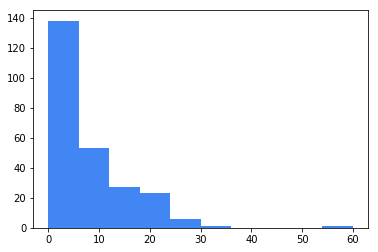

In [11]:
plt.hist(score_df[~score_df['adversary']]['average'], color='#4286f4', range=[0,60])

(array([   2.,    9.,   48.,  110.,  111.,   83.,   44.,   20.,   10.,    4.]),
 array([  0.,   6.,  12.,  18.,  24.,  30.,  36.,  42.,  48.,  54.,  60.]),
 <a list of 10 Patch objects>)

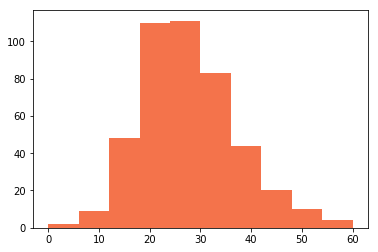

In [12]:
plt.hist(score_df[score_df['adversary']]['average'], color='#f4734b', range=[0,60])

In [13]:
true_mean = score_df[~score_df['adversary']]['average'].mean(axis=0)
true_std = score_df[~score_df['adversary']]['average'].std(axis=0)
fscoredf = []
for f in test_graphmls:
    col = {}
    col['adversary'] = False
    g = nx.read_graphml(join(GRAPH_LOC, f))
    for node in g.nodes():
        if node[len(node)-1] == '3':
            g.remove_node(node)
    j,score,scores = rank_match(g.nodes(), tdf)
    ascore = np.mean(np.array(list(scores.values())))
    if ascore > true_mean + true_std:
        col['flagged'] = True
        col['flagged_amount'] = ascore - true_mean + true_std
    else:
        col['flagged'] = False
        col['flagged_amount'] = true_mean + true_std - ascore
    fscoredf.append(col)
for f in adv_graphmls:
    col = {}
    col['adversary'] = True
    g = nx.read_graphml(join(ADV_GRAPH_LOC, f))
    for node in g.nodes():
        if node[len(node)-1] == '3':
            g.remove_node(node)
    j,score,scores = rank_match(g.nodes(), tdf)
    ascore = np.mean(np.array(list(scores.values())))
    if ascore > true_mean + true_std:
        col['flagged'] = True
        col['flagged_amount'] = ascore - true_mean + true_std
    else:
        col['flagged'] = False
        col['flagged_amount'] = true_mean + true_std - ascore
    fscoredf.append(col)
fscoredf = pd.DataFrame(fscoredf)

In [14]:
fscoredf.head()

,adversary,flagged,flagged_amount
0,False,False,15.912275
1,False,False,14.912275
2,False,False,0.012275
3,False,False,15.912275
4,False,False,16.612275


In [15]:
print("Number of adversaries: ", fscoredf[fscoredf['adversary']].shape[0], "Number of non-adversaries: ", fscoredf[~fscoredf['adversary']].shape[0])

('Number of adversaries: ', 450, 'Number of non-adversaries: ', 449)


In [63]:
def fscore(fscoredf):
    fp = fscoredf[~fscoredf['adversary'] & fscoredf['flagged']].shape[0]
    fpm = fscoredf[~fscoredf['adversary'] & fscoredf['flagged']]['flagged_amount'].mean()
    tp = fscoredf[fscoredf['adversary'] & fscoredf['flagged']].shape[0]
    fn = fscoredf[fscoredf['adversary'] & ~fscoredf['flagged']].shape[0]
    fnm = fscoredf[fscoredf['adversary'] & ~fscoredf['flagged']]['flagged_amount'].mean()
    acc =  (fscoredf[~fscoredf['adversary'] & ~fscoredf['flagged']].shape[0] + fscoredf[fscoredf['adversary'] & fscoredf['flagged']].shape[0])/float(fscoredf.shape[0])
    precision = float(tp) / float(tp + fp)
    recall = float(tp) / float(tp + fn)
    fs = 2 * precision * recall /(precision + recall)
    print("Number false positives: ", fp)
    print("Average FP Miss: ", fpm)
    print("Number false negatives: ", fn)
    print("Average FN Miss: ", fnm)
    print("Accuracy: ",acc)
    print("f1_score: ", fs)
    return {'false positives':fp, 'false negatives':fn, 'accuracy':acc, 'fscore': fs}

In [64]:
fscore(fscoredf)

('Number false positives: ', 45)
('Average FP Miss: ', 29.803298051898008)
('Number false negatives: ', 58)
('Average FN Miss: ', 3.4950340962264392)
('Accuracy: ', 0.8854282536151279)
('f1_score: ', 0.8838782412626832)


{'accuracy': 0.8854282536151279,
 'false negatives': 58,
 'false positives': 45,
 'fscore': 0.8838782412626832}

In [18]:
g2 = nx.read_graphml(join(GRAPH_LOC, '0_10.graphml'))
g3 = nx.Graph()
for e1, e2, data in g2.edges(data=True):
    g3.add_edge(e1, e2, weight=data['weight'])

/home/tgebhart/.virtualenvs/tf_activation/local/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/tgebhart/.virtualenvs/tf_activation/local/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/tgebhart/.virtualenvs/tf_activation/local/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/tgebhart/.virtualenvs/tf_activation/local/lib/python2.7/site-packages/matplotlib/rcset

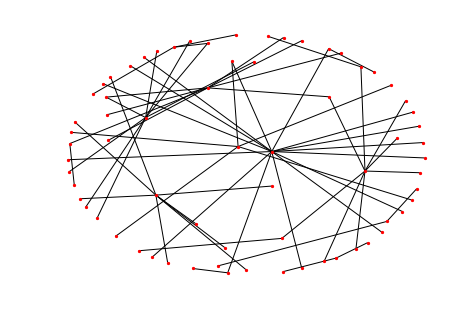

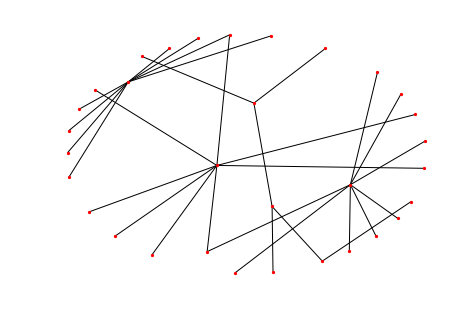

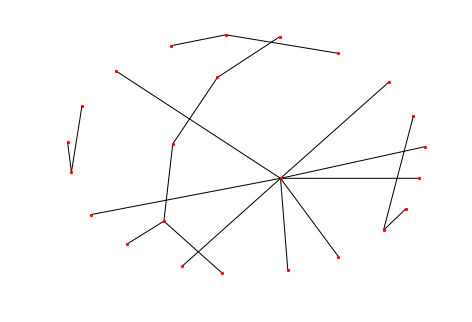

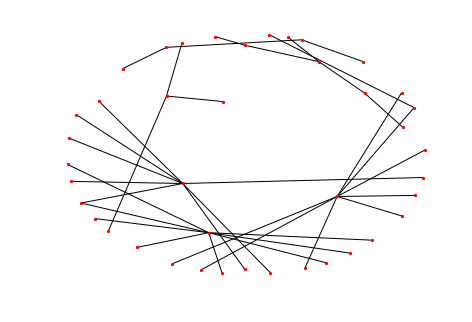

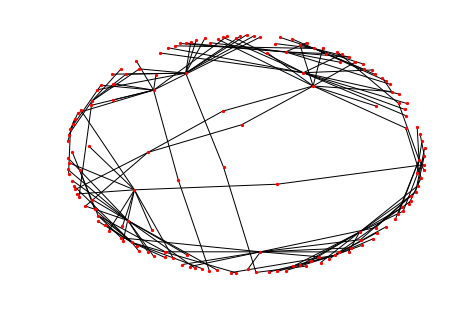

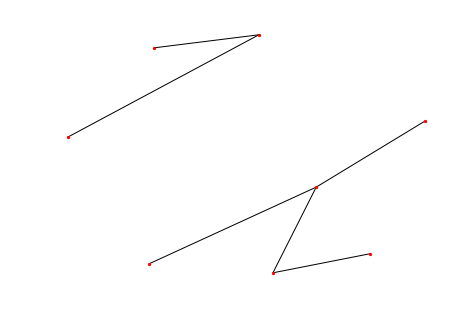

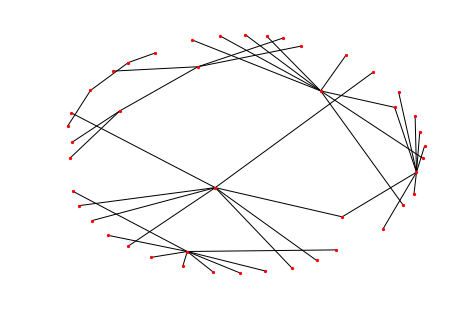

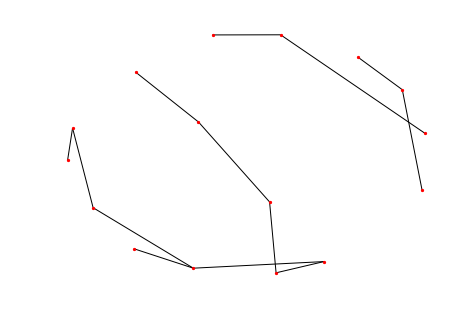

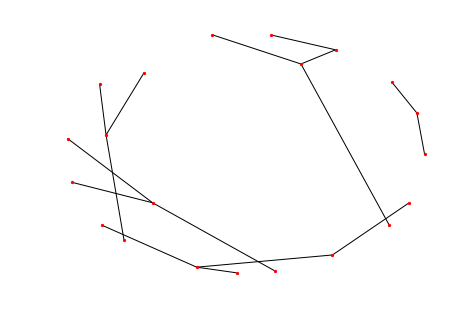

In [19]:
for i in range(1,10):
    g2 = nx.read_graphml(join(GRAPH_LOC, graphmls[i]))
    g3 = nx.Graph()
    for e1, e2, data in g2.edges(data=True):
        g3.add_edge(e1, e2, weight=data['weight'])
    nx.draw_spring(g3, node_size=5, iterations=100)
    plt.show()
    plt.close()

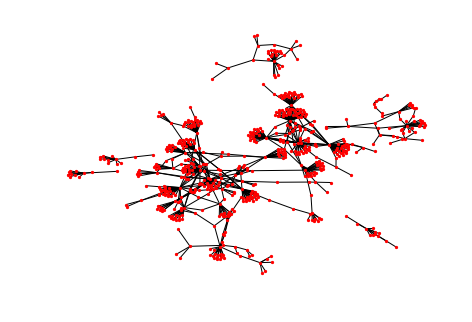

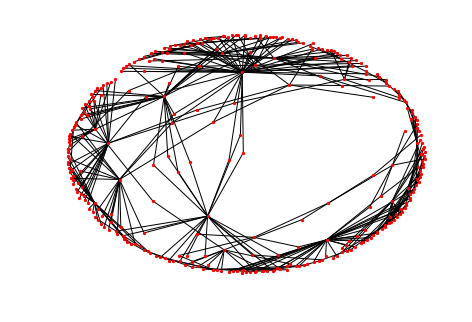

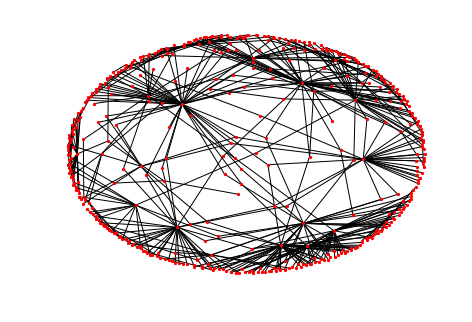

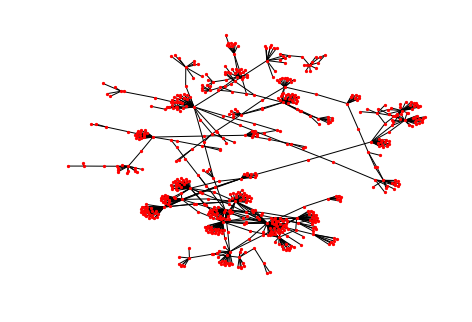

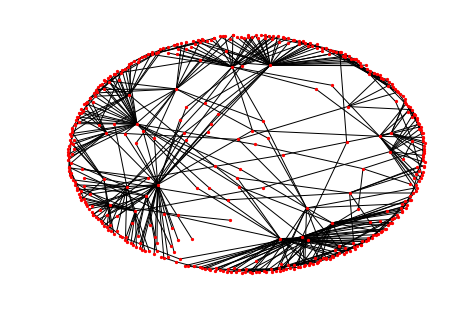

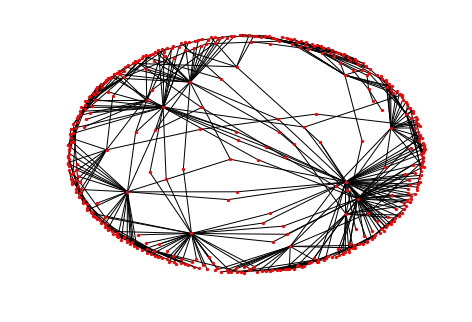

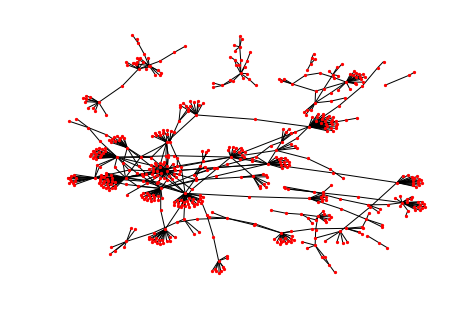

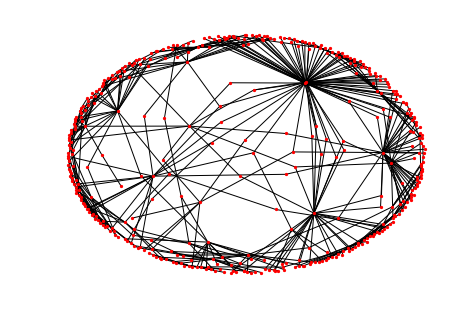

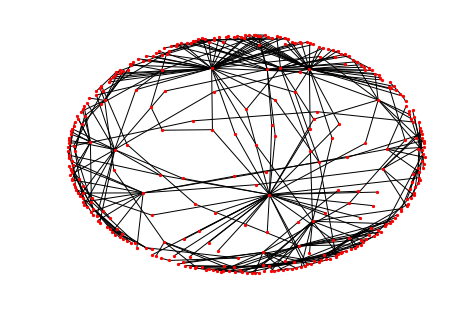

In [20]:
for i in range(1,10):
    g2 = nx.read_graphml(join(ADV_GRAPH_LOC, '0_'+str(i)+'_10.graphml'))
    g3 = nx.Graph()
    for e1, e2, data in g2.edges(data=True):
        g3.add_edge(e1, e2, weight=data['weight'])
    nx.draw_spring(g3, node_size=5, iterations=100)
    plt.show()
    plt.close()

In [21]:
all_graphmls = [f for f in listdir(GRAPH_LOC) if isfile(join(GRAPH_LOC, f))]
weights = np.zeros(shape=len(all_graphmls))
for i in range(len(all_graphmls)):
    f = all_graphmls[i]
    g2 = nx.read_graphml(join(GRAPH_LOC, f))
    g3 = nx.Graph()
    weight = 0
    for e1, e2, data in g2.edges(data=True):
        weight += data['weight']
    if (len(g2.edges()) > 0):
        weights[i] = weight/len(g2.edges())
print("Average Weights Non-Adversary: ", np.mean(weights))
print("Stdev Weights Non-Adversary: ", np.std(weights))

('Average Weights Non-Adversary: ', 0.48963326655303696)
('Stdev Weights Non-Adversary: ', 0.19625057084232544)


In [22]:
adv_weights = np.zeros(shape=len(adv_graphmls))
for i in range(len(adv_graphmls)):
    f = adv_graphmls[i]
    g2 = nx.read_graphml(join(ADV_GRAPH_LOC, f))
    g3 = nx.Graph()
    weight = 0
    for e1, e2, data in g2.edges(data=True):
        weight += data['weight']
    if (len(g2.edges()) > 0):
        adv_weights[i] = weight/len(g2.edges())
print("Average Weights Adversary: ", np.mean(adv_weights))
print("Stdev Weights Adversary:", np.std(adv_weights))

('Average Weights Adversary: ', 0.2336868193785599)
('Stdev Weights Adversary:', 0.040819263183491092)


In [23]:
print(ttest_ind(weights, adv_weights))
print(mannwhitneyu(weights, adv_weights, alternative='two-sided'))

Ttest_indResult(statistic=27.381542997860954, pvalue=2.2842884034222788e-133)
MannwhitneyuResult(statistic=431495.0, pvalue=1.9426638477538851e-172)


In [24]:
edges = np.zeros(shape=len(all_graphmls))
for i in range(len(all_graphmls)):
    f = all_graphmls[i]
    g2 = nx.read_graphml(join(GRAPH_LOC, f))
    edges[i] = len(g2.edges())
print("Average Edges Non-Adversary: ", np.mean(edges))
print("Stdev Edges Non-Adversary: ", np.std(edges))

('Average Edges Non-Adversary: ', 489.214)
('Stdev Edges Non-Adversary: ', 7839.2022965480355)


In [25]:
adv_edges = np.zeros(shape=len(adv_graphmls))
for i in range(len(adv_graphmls)):
    f = adv_graphmls[i]
    g2 = nx.read_graphml(join(ADV_GRAPH_LOC, f))
    adv_edges[i] = len(g2.edges())
print("Average Edges Adversary: ", np.mean(adv_edges))
print("Stdev Edges Adversary: ", np.std(adv_edges))

('Average Edges Adversary: ', 7870.9666666666662)
('Stdev Edges Adversary: ', 24913.139700902146)


In [26]:
print(ttest_ind(edges, adv_edges))
print(mannwhitneyu(edges, adv_edges, alternative='less'))

Ttest_indResult(statistic=-8.4770888681438414, pvalue=5.6069393237628879e-17)
MannwhitneyuResult(statistic=6520.0, pvalue=4.25590189998867e-193)


In [117]:
def average_edge_weight(g):
    weight = 0
    for e1, e2, data in g.edges(data=True):
        weight += data['weight']
    if (len(g.edges()) > 0):
        return weight/len(g.edges())
    return 0

def average_edge_weights(graphmls, directory):
    weights = np.zeros(shape=len(graphmls))
    for i in range(len(graphmls)):
        f = graphmls[i]
        g = nx.read_graphml(join(directory, f))
        weights[i] = average_edge_weight(g)
    return weights

def num_edges(graphmls, directory):
    edges = np.zeros(shape=len(graphmls))
    for i in range(len(graphmls)):
        f = graphmls[i]
        g = nx.read_graphml(join(directory, f))
        edges[i] = len(g.edges())
    return edges
        

In [28]:
train_avg_edge_weights = average_edge_weights(graphmls + val_graphmls, GRAPH_LOC)

In [29]:
true_mean = np.mean(train_avg_edge_weights)
true_std = np.std(train_avg_edge_weights)
fscoredf_w = []
for f in test_graphmls:
    col = {}
    col['adversary'] = False
    g = nx.read_graphml(join(GRAPH_LOC, f))
    ascore = average_edge_weight(g)
    if ascore < true_mean - true_std:
        col['flagged'] = True
        col['flagged_amount'] = true_mean - true_std - ascore
    else:
        col['flagged'] = False
        col['flagged_amount'] = ascore - true_mean - true_std 
    fscoredf_w.append(col)
for f in adv_graphmls:
    col = {}
    col['adversary'] = True
    g = nx.read_graphml(join(ADV_GRAPH_LOC, f))
    ascore = average_edge_weight(g)
    if ascore < true_mean - true_std:
        col['flagged'] = True
        col['flagged_amount'] = true_mean - true_std - ascore
    else:
        col['flagged'] = False
        col['flagged_amount'] = ascore - true_mean - true_std
    fscoredf_w.append(col)
fscoredf_w = pd.DataFrame(fscoredf_w)
fscoredf_w.head()

,adversary,flagged,flagged_amount
0,False,False,-0.075530
1,False,False,-0.163399
2,False,False,-0.304104
3,False,False,-0.010002
4,False,False,0.079217


In [65]:
fscore(fscoredf_w)

('Number false positives: ', 30)
('Average FP Miss: ', 0.068820096678719286)
('Number false negatives: ', 47)
('Average FN Miss: ', -0.36749767062273675)
('Accuracy: ', 0.914349276974416)
('f1_score: ', 0.912797281993205)


{'accuracy': 0.914349276974416,
 'false negatives': 47,
 'false positives': 30,
 'fscore': 0.912797281993205}

(array([   3.,   33.,  170.,  417.,  144.,   95.,   72.,   29.,   26.,   10.]),
 array([ 0.  ,  0.12,  0.24,  0.36,  0.48,  0.6 ,  0.72,  0.84,  0.96,
         1.08,  1.2 ]),
 <a list of 10 Patch objects>)

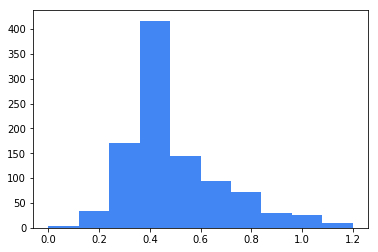

In [31]:
plt.hist(weights, color='#4286f4', range=[0,1.2])

(array([   1.,  269.,  179.,    1.,    0.,    0.,    0.,    0.,    0.,    0.]),
 array([ 0.  ,  0.12,  0.24,  0.36,  0.48,  0.6 ,  0.72,  0.84,  0.96,
         1.08,  1.2 ]),
 <a list of 10 Patch objects>)

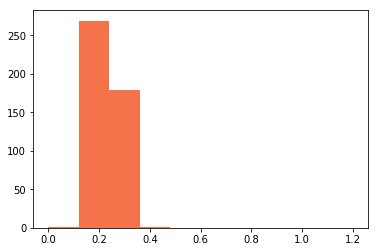

In [32]:
plt.hist(adv_weights, color='#f4734b', range=[0,1.2])

In [162]:
ne = num_edges(graphmls + val_graphmls, GRAPH_LOC)
nea = num_edges(adv_graphmls,ADV_GRAPH_LOC)

In [163]:
p = np.percentile(ne, 90)
p

164.0

In [164]:
np.median(ne)

56.0

In [165]:
true_mean = np.median(ne)
true_std = np.percentile(ne, 90)
fscoredf_ne = []
for f in test_graphmls:
    col = {}
    col['adversary'] = False
    g = nx.read_graphml(join(GRAPH_LOC, f))
    ascore = len(g.edges())
    if ascore > true_mean + true_std:
        col['flagged'] = True
        col['flagged_amount'] = true_mean - true_std - ascore
    else:
        col['flagged'] = False
        col['flagged_amount'] = ascore - true_mean - true_std 
    fscoredf_ne.append(col)
for f in adv_graphmls:
    col = {}
    col['adversary'] = True
    g = nx.read_graphml(join(ADV_GRAPH_LOC, f))
    ascore = len(g.edges())
    if ascore > true_mean + true_std:
        col['flagged'] = True
        col['flagged_amount'] = true_mean - true_std - ascore
    else:
        col['flagged'] = False
        col['flagged_amount'] = ascore - true_mean - true_std
    fscoredf_ne.append(col)
fscoredf_ne = pd.DataFrame(fscoredf_ne)
fscoredf_ne.head()

,adversary,flagged,flagged_amount
0,False,False,-206.0
1,False,False,-200.0
2,False,False,-109.0
3,False,False,-207.0
4,False,False,-210.0


In [166]:
fscore(fscoredf_ne)

('Number false positives: ', 18)
('Average FP Miss: ', -1821.3888888888889)
('Number false negatives: ', 10)
('Average FN Miss: ', -48.700000000000003)
('Accuracy: ', 0.9688542825361512)
('f1_score: ', 0.9691629955947135)


{'accuracy': 0.9688542825361512,
 'false negatives': 10,
 'false positives': 18,
 'fscore': 0.9691629955947135}

(array([ 548.,    0.,    2.,    0.,    0.,    0.,    0.,    0.,    0.,    1.]),
 array([      0. ,   23008.4,   46016.8,   69025.2,   92033.6,  115042. ,
         138050.4,  161058.8,  184067.2,  207075.6,  230084. ]),
 <a list of 10 Patch objects>)

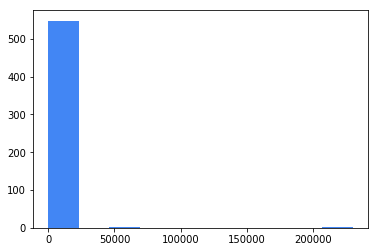

In [159]:
plt.hist(ne, color='#4286f4')

(array([ 423.,   10.,    5.,    4.,    1.,    2.,    2.,    1.,    1.,    1.]),
 array([  9.00000000e+01,   2.46526000e+04,   4.92152000e+04,
          7.37778000e+04,   9.83404000e+04,   1.22903000e+05,
          1.47465600e+05,   1.72028200e+05,   1.96590800e+05,
          2.21153400e+05,   2.45716000e+05]),
 <a list of 10 Patch objects>)

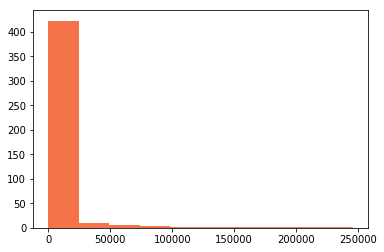

In [148]:
plt.hist(nea, color='#f4734b')

In [33]:
def edge_matching(g, gs, how='weighted'):
    for node in g.nodes():
        if node[len(node)-1] == '3':
            g.remove_node(node)
    g = get_weighted_graph(g)
    if how == 'weighted':
        return weighted_edge_matches(g,gs)
    if how == 'rank':
        return rank_edge_matches(g,gs)

def rank_edge_matches(g, gs):
    scores = {}
    best_score = 0
    best_match = None
    for i in range(len(gs)):
        scores[i] = rank_edge_match(g, gs[i])
        if scores[i] > best_score:
            best_score = scores[i]
            best_match = i
    return best_match, best_score, scores

def weighted_edge_matches(g, gs):
    scores = {}
    best_score = 0
    best_match = None
    for i in range(len(gs)):
        scores[i] = weighted_edge_match(g, gs[i])
        if scores[i] > best_score:
            best_score = scores[i]
            best_match = i
    return best_match, best_score, scores

def weighted_edge_match(g1, g2):
    score = 0
    edges_g1 = len(g1.edges())
    edges_g2 = len(g2.edges())
    for e1 in g1.edges():
        if e1 in g2.edges(): 
            score += (1 + 1/(1+(np.abs(g1[e1[0]][e1[1]]['weight'] - g2[e1[0]][e1[1]]['weight']))))
    return score / (edges_g2)

def rank_edge_match(g1, g2):
    score = 0
    edges_g1 = len(g1.edges())
    edge_rankings = generate_ranking(g2)
    edge_rankings.sort_values('num', ascending=False, inplace=True)
    edges_g2 = edge_rankings.shape[0]
    for i in range(edges_g2):
        if edge_rankings.iloc[i]['edge'] in g1.edges():
            score += (edges_g2 - i)
    return float(score) / float(edges_g2)

def generate_ranking(g):
    ret = []
    for u,v,data in g.edges(data=True):
        ret.append({'edge':(u,v), 'num':data['num']})
    return pd.DataFrame(ret)

def get_weighted_graph(g):
    gret = nx.Graph()
    for e1, e2, data in g.edges(data=True):
        gret.add_edge(e1, e2, weight=data['weight'])
    return gret

In [34]:
tgs = []
for i in range(10):
    tg = nx.Graph()
    print("Step {}".format(i))
    for f in graphmls:
        if f[0] == str(i):
            print(f)
            col = {}
            g = nx.read_graphml(join(GRAPH_LOC, f))
            for node in g.nodes():
                if node[len(node)-1] == '3':
                    g.remove_node(node)
            g = get_weighted_graph(g)
            for u,v,data in g.edges(data=True):
                if tg.has_edge(u,v):
                    tg[u][v]['weight'] += data['weight']
                    tg[u][v]['num'] += 1
                else:
                    tg.add_edge(u,v,attr_dict={'num':1}, weight=data['weight'])
    for u,v,data in tg.edges(data=True):
        tg[u][v]['weight'] = data['weight']/data['num']
    tgs.append(tg)

Step 0
0_115.graphml
0_133.graphml
0_131.graphml
0_82.graphml
0_272.graphml
0_15.graphml
0_167.graphml
0_202.graphml
0_275.graphml
0_285.graphml
0_7.graphml
0_244.graphml
0_192.graphml
0_72.graphml
0_268.graphml
0_96.graphml
0_154.graphml
0_74.graphml
0_10.graphml
0_187.graphml
0_53.graphml
0_52.graphml
0_249.graphml
0_286.graphml
0_120.graphml
0_144.graphml
0_147.graphml
0_48.graphml
0_194.graphml
0_288.graphml
0_196.graphml
0_108.graphml
0_228.graphml
0_246.graphml
0_298.graphml
0_203.graphml
0_19.graphml
0_83.graphml
0_266.graphml
Step 1
1_12.graphml
1_239.graphml
1_221.graphml
1_123.graphml
1_176.graphml
1_169.graphml
1_23.graphml
1_237.graphml
1_256.graphml
1_234.graphml
1_235.graphml
1_54.graphml
1_114.graphml
1_58.graphml
1_20.graphml
1_51.graphml
1_168.graphml
1_225.graphml
1_90.graphml
1_75.graphml
1_245.graphml
1_6.graphml
1_128.graphml
1_132.graphml
1_189.graphml
1_262.graphml
1_73.graphml
1_271.graphml
1_107.graphml
1_4.graphml
1_149.graphml
1_204.graphml
1_174.graphml
Step

In [35]:
score_df_e = []
for f in adv_graphmls:
    j,score,scores = edge_matching(nx.read_graphml(join(ADV_GRAPH_LOC, f)), tgs)
    scores['adversary'] = True
    scores['true'] = f[0]
    scores['predicted'] = f[2]
    score_df_e.append(scores)
for f in val_graphmls:
    j,score,scores = edge_matching(nx.read_graphml(join(GRAPH_LOC, f)), tgs)
    scores['adversary'] = False
    scores['true'] = f[0]
    scores['predicted'] = f[0]
    score_df_e.append(scores)
score_df_e = pd.DataFrame(score_df_e)
score_df_e.head()

,0,1,2,3,4,5,6,7,8,9,adversary,predicted,true
0,0.009885,0.030011,0.047395,0.031958,0.012307,0.061203,0.034981,0.021866,0.013255,0.037387,True,2,0
1,0.011248,0.052227,0.055817,0.070377,0.010761,0.098377,0.090665,0.003260,0.028543,0.039726,True,7,6
2,0.021339,0.024886,0.059687,0.065832,0.022845,0.088166,0.082400,0.012204,0.020680,0.046784,True,0,9
3,0.006699,0.069244,0.042203,0.035049,0.017280,0.078778,0.029681,0.034883,0.017615,0.040140,True,4,3
4,0.007246,0.023080,0.058558,0.010267,0.013120,0.025987,0.023627,0.027186,0.006487,0.034089,True,2,7


In [36]:
score_df_e['average'] = score_df_e.drop(['adversary', 'predicted', 'true'], axis=1).mean(numeric_only=True, axis=1)

In [37]:
score_df_e[~score_df_e['adversary']].head()

,0,1,2,3,4,5,6,7,8,9,adversary,predicted,true,average
450,0.008800,0.010662,0.017688,0.016091,0.008947,0.067660,0.047505,0.008966,0.020850,0.033832,False,8,8,0.024100
451,0.013003,0.021433,0.033573,0.062587,0.012880,0.050105,0.031185,0.012255,0.026008,0.036369,False,8,8,0.029940
452,0.001567,0.010719,0.042434,0.025052,0.003942,0.038590,0.017633,0.007330,0.010427,0.014313,False,9,9,0.017201
453,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False,4,4,0.000000
454,0.000000,0.001738,0.008847,0.007159,0.002485,0.000000,0.005427,0.000812,0.003724,0.006506,False,8,8,0.003670


In [38]:
score_df_e[score_df_e['adversary']].head()

,0,1,2,3,4,5,6,7,8,9,adversary,predicted,true,average
0,0.009885,0.030011,0.047395,0.031958,0.012307,0.061203,0.034981,0.021866,0.013255,0.037387,True,2,0,0.030025
1,0.011248,0.052227,0.055817,0.070377,0.010761,0.098377,0.090665,0.003260,0.028543,0.039726,True,7,6,0.046100
2,0.021339,0.024886,0.059687,0.065832,0.022845,0.088166,0.082400,0.012204,0.020680,0.046784,True,0,9,0.044482
3,0.006699,0.069244,0.042203,0.035049,0.017280,0.078778,0.029681,0.034883,0.017615,0.040140,True,4,3,0.037157
4,0.007246,0.023080,0.058558,0.010267,0.013120,0.025987,0.023627,0.027186,0.006487,0.034089,True,2,7,0.022965


In [39]:
print(score_df_e[~score_df_e['adversary']]['average'].mean(axis=0))
print(score_df_e[~score_df_e['adversary']]['average'].std(axis=0))
print(score_df_e[score_df_e['adversary']]['average'].mean(axis=0))
print(score_df_e[score_df_e['adversary']]['average'].std(axis=0))

0.00963837160844
0.0126327329343
0.038749298072
0.0123223053756


(array([ 151.,   24.,   30.,   18.,   15.,    7.,    3.,    3.,    0.,    0.]),
 array([ 0.   ,  0.007,  0.014,  0.021,  0.028,  0.035,  0.042,  0.049,
         0.056,  0.063,  0.07 ]),
 <a list of 10 Patch objects>)

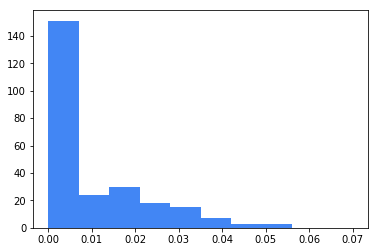

In [73]:
plt.hist(score_df_e[~score_df_e['adversary']]['average'], color='#4286f4', range=[0,0.07])

(array([  2.,   6.,  19.,  66.,  90.,  84.,  93.,  49.,  28.,  12.]),
 array([ 0.   ,  0.007,  0.014,  0.021,  0.028,  0.035,  0.042,  0.049,
         0.056,  0.063,  0.07 ]),
 <a list of 10 Patch objects>)

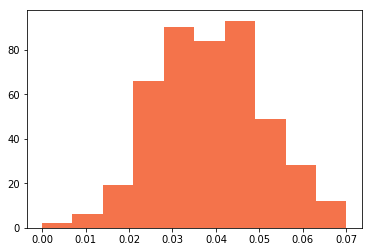

In [72]:
plt.hist(score_df_e[score_df_e['adversary']]['average'], color='#f4734b', range=[0,0.07])

In [42]:
fscoredf_e = []
true_mean = score_df_e[~score_df_e['adversary']]['average'].mean(axis=0)
true_std = score_df_e[~score_df_e['adversary']]['average'].std(axis=0)
for f in test_graphmls:
    col = {}
    col['adversary'] = False
    g = nx.read_graphml(join(GRAPH_LOC, f))
    bm,bs,s = edge_matching(g,tgs)
    ascore = np.mean(np.array(list(s.values())))
    if ascore > true_mean + true_std:
        col['flagged'] = True
        col['flagged_amount'] = ascore - true_mean + true_std
    else:
        col['flagged'] = False
        col['flagged_amount'] = true_mean + true_std - ascore
    fscoredf_e.append(col)
for f in adv_graphmls:
    col = {}
    col['adversary'] = True
    g = nx.read_graphml(join(ADV_GRAPH_LOC, f))
    bm,bs,s = edge_matching(g,tgs)
    ascore = np.mean(np.array(list(s.values())))
    if ascore > true_mean + true_std:
        col['flagged'] = True
        col['flagged_amount'] = ascore - true_mean + true_std
    else:
        col['flagged'] = False
        col['flagged_amount'] = true_mean + true_std - ascore
    fscoredf_e.append(col)
fscoredf_e = pd.DataFrame(fscoredf_e)
fscoredf_e.head()

,adversary,flagged,flagged_amount
0,False,False,0.022146
1,False,False,0.021619
2,False,True,0.028731
3,False,False,0.022137
4,False,False,0.022140


In [66]:
fscore(fscoredf_e)

('Number false positives: ', 77)
('Average FP Miss: ', 0.033939662228084484)
('Number false negatives: ', 36)
('Average FN Miss: ', 0.0051871750205283521)
('Accuracy: ', 0.8743047830923248)
('f1_score: ', 0.8799149840595112)


{'accuracy': 0.8743047830923248,
 'false negatives': 36,
 'false positives': 77,
 'fscore': 0.8799149840595112}

In [44]:
score_df_re = []
for f in adv_graphmls:
    j,score,scores = edge_matching(nx.read_graphml(join(ADV_GRAPH_LOC, f)), tgs, how='rank')
    scores['adversary'] = True
    scores['true'] = f[0]
    scores['predicted'] = f[2]
    score_df_re.append(scores)
for f in val_graphmls:
    j,score,scores = edge_matching(nx.read_graphml(join(GRAPH_LOC, f)), tgs, how='rank')
    scores['adversary'] = False
    scores['true'] = f[0]
    scores['predicted'] = f[0]
    score_df_re.append(scores)
score_df_re = pd.DataFrame(score_df_re)
score_df_re.head()

,0,1,2,3,4,5,6,7,8,9,adversary,predicted,true
0,10.002090,11.012511,16.922124,12.139660,15.346594,18.472921,13.173234,20.521259,12.715990,14.330078,True,2,0
1,12.090125,16.872207,10.746018,27.993733,11.584784,23.579304,33.579484,2.653720,23.731644,20.761068,True,7,6
2,24.065047,7.134942,21.649558,24.645479,33.041522,24.516441,34.794158,9.137367,15.054044,19.437500,True,0,9
3,7.794932,23.829312,13.702655,13.411817,17.383391,25.761122,7.806386,25.841783,11.514350,18.678385,True,4,3
4,8.320533,10.421805,19.442478,2.343778,16.524117,6.115087,7.614810,24.447261,6.216549,11.583333,True,2,7


In [45]:
score_df_re['average'] = score_df_re.drop(['adversary', 'predicted', 'true'], axis=1).mean(numeric_only=True, axis=1)

In [46]:
print(score_df_re[~score_df_re['adversary']]['average'].mean(axis=0))
print(score_df_re[~score_df_re['adversary']]['average'].std(axis=0))
print(score_df_re[score_df_re['adversary']]['average'].mean(axis=0))
print(score_df_re[score_df_re['adversary']]['average'].std(axis=0))

4.50804191889
5.92781071769
17.3918883333
5.58752067598


In [47]:
score_df_re[~score_df_re['adversary']].head(10)

,0,1,2,3,4,5,6,7,8,9,adversary,predicted,true,average
450,7.803814,1.619303,4.584956,3.239928,12.756837,15.462282,18.833560,6.174162,20.512859,9.506510,False,8,8,10.049421
451,14.254963,8.668454,13.943363,27.525515,12.106663,10.864603,14.447690,8.662306,23.704063,13.408203,False,8,8,14.758582
452,2.891066,0.608579,14.100885,11.109221,6.225261,12.459381,4.720788,5.286182,11.589638,5.992839,False,9,9,7.498384
453,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False,4,4,0.000000
454,0.000000,0.100089,4.343363,3.028648,3.232223,0.000000,2.328804,0.667621,4.427507,2.669271,False,8,8,2.079753
455,1.696708,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.806560,0.000000,False,0,0,0.550327
456,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.788723,0.000000,0.100634,0.000000,False,4,4,0.088936
457,5.906740,0.000000,0.000000,2.160251,5.991546,0.000000,0.000000,0.000000,0.000000,2.148438,False,9,9,1.620697
458,3.764107,0.000000,0.000000,0.000000,0.000000,0.603482,0.000000,0.000000,0.749907,0.000000,False,0,0,0.511750
459,0.000000,0.000000,0.678761,0.000000,0.000000,0.000000,0.000000,0.000000,1.569884,0.000000,False,8,8,0.224865


In [48]:
score_df_re[score_df_re['adversary']].head(10)

,0,1,2,3,4,5,6,7,8,9,adversary,predicted,true,average
0,10.002090,11.012511,16.922124,12.139660,15.346594,18.472921,13.173234,20.521259,12.715990,14.330078,True,2,0,14.463646
1,12.090125,16.872207,10.746018,27.993733,11.584784,23.579304,33.579484,2.653720,23.731644,20.761068,True,7,6,18.359209
2,24.065047,7.134942,21.649558,24.645479,33.041522,24.516441,34.794158,9.137367,15.054044,19.437500,True,0,9,21.347606
3,7.794932,23.829312,13.702655,13.411817,17.383391,25.761122,7.806386,25.841783,11.514350,18.678385,True,4,3,16.572413
4,8.320533,10.421805,19.442478,2.343778,16.524117,6.115087,7.614810,24.447261,6.216549,11.583333,True,2,7,11.302975
5,5.725967,10.404826,21.925664,29.821844,29.580060,7.086074,8.877717,22.514309,19.156541,17.880208,True,0,7,17.297321
6,13.939916,31.161752,22.753097,12.433303,9.109150,26.883946,16.547554,5.878577,21.522549,10.805990,True,8,1,17.103583
7,20.165622,16.740840,9.480531,12.291853,4.970661,12.629594,15.459918,14.063778,27.163623,6.198568,True,0,1,13.916499
8,20.614420,19.643432,18.526549,19.750224,13.404276,17.130561,17.206522,15.602208,34.368245,23.180990,True,3,5,19.942743
9,41.667712,30.372654,28.198230,31.056401,10.149925,19.854932,25.616168,9.577678,24.521804,21.947266,True,4,2,24.296277


(array([ 153.,   29.,   25.,   19.,   15.,    5.,    5.,    0.,    0.,    0.]),
 array([  0. ,   3.5,   7. ,  10.5,  14. ,  17.5,  21. ,  24.5,  28. ,
         31.5,  35. ]),
 <a list of 10 Patch objects>)

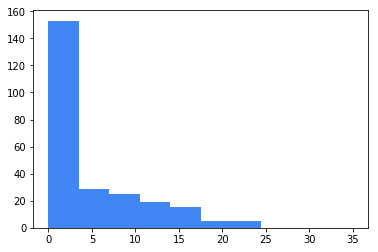

In [74]:
plt.hist(score_df_re[~score_df_re['adversary']]['average'], color='#4286f4', range=[0,35])

(array([   2.,    7.,   35.,   88.,  103.,   97.,   71.,   33.,   11.,    3.]),
 array([  0. ,   3.5,   7. ,  10.5,  14. ,  17.5,  21. ,  24.5,  28. ,
         31.5,  35. ]),
 <a list of 10 Patch objects>)

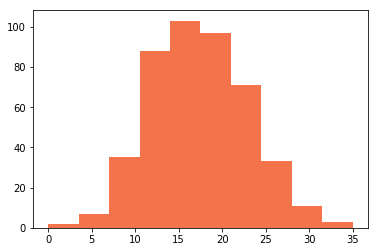

In [75]:
plt.hist(score_df_re[score_df_re['adversary']]['average'], color='#f4734b', range=[0,35])

In [51]:
fscoredf_re = []
true_mean = score_df_re[~score_df_re['adversary']]['average'].mean(axis=0)
true_std = score_df_re[~score_df_re['adversary']]['average'].std(axis=0)
for f in test_graphmls:
    col = {}
    col['adversary'] = False
    g = nx.read_graphml(join(GRAPH_LOC, f))
    bm,bs,s = edge_matching(g,tgs, how='rank')
    ascore = np.mean(np.array(list(s.values())))
    if ascore > true_mean + true_std:
        col['flagged'] = True
        col['flagged_amount'] = ascore - true_mean + true_std
    else:
        col['flagged'] = False
        col['flagged_amount'] = true_mean + true_std - ascore
    fscoredf_re.append(col)
for f in adv_graphmls:
    col = {}
    col['adversary'] = True
    g = nx.read_graphml(join(ADV_GRAPH_LOC, f))
    bm,bs,s = edge_matching(g,tgs, how='rank')
    ascore = np.mean(np.array(list(s.values())))
    if ascore > true_mean + true_std:
        col['flagged'] = True
        col['flagged_amount'] = ascore - true_mean + true_std
    else:
        col['flagged'] = False
        col['flagged_amount'] = true_mean + true_std - ascore
    fscoredf_re.append(col)
fscoredf_re = pd.DataFrame(fscoredf_re)
fscoredf_re.head()

,adversary,flagged,flagged_amount
0,False,False,10.278973
1,False,False,10.333736
2,False,True,15.235315
3,False,False,10.418258
4,False,False,10.321682


In [67]:
fscore(fscoredf_re)

('Number false positives: ', 72)
('Average FP Miss: ', 16.113758142260963)
('Number false negatives: ', 43)
('Average FN Miss: ', 2.3851873054925625)
('Accuracy: ', 0.8720800889877642)
('f1_score: ', 0.876210979547901)


{'accuracy': 0.8720800889877642,
 'false negatives': 43,
 'false positives': 72,
 'fscore': 0.876210979547901}

In [55]:
score_df_m = []
for f in adv_graphmls:
    j,score,scores = match(nx.read_graphml(join(ADV_GRAPH_LOC, f)).nodes(), tdf)
    scores['adversary'] = True
    scores['true'] = f[0]
    scores['predicted'] = f[2]
    score_df_m.append(scores)
for f in val_graphmls:
    j,score,scores = match(nx.read_graphml(join(GRAPH_LOC, f)).nodes(), tdf)
    scores['adversary'] = False
    scores['true'] = f[0]
    scores['predicted'] = f[0]
    score_df_m.append(scores)
score_df_m = pd.DataFrame(score_df_m)
score_df_m.head()

,0,1,2,3,4,5,6,7,8,9,adversary,predicted,true
0,0.061265,0.133333,0.137255,0.105856,0.062565,0.085714,0.063745,0.110124,0.097421,0.108499,True,2,0
1,0.079051,0.146154,0.103641,0.166667,0.102190,0.219048,0.233068,0.074600,0.164756,0.137432,True,7,6
2,0.043478,0.046154,0.126050,0.132883,0.071950,0.155556,0.111554,0.060391,0.088825,0.117541,True,0,9
3,0.057312,0.117949,0.156863,0.195946,0.090719,0.250794,0.095618,0.143872,0.124642,0.128391,True,4,3
4,0.057312,0.071795,0.187675,0.114865,0.076121,0.130159,0.071713,0.156306,0.088825,0.135624,True,2,7


In [56]:
score_df_m['average'] = score_df_m.drop(['adversary', 'predicted', 'true'], axis=1).mean(numeric_only=True, axis=1)

In [57]:
print(score_df_m[~score_df_m['adversary']]['average'].mean(axis=0))
print(score_df_m[~score_df_m['adversary']]['average'].std(axis=0))
print(score_df_m[score_df_m['adversary']]['average'].mean(axis=0))
print(score_df_m[score_df_m['adversary']]['average'].std(axis=0))

0.0292472958202
0.0311260460127
0.108385354601
0.0414458973339


(array([ 180.,   56.,   12.,    0.,    2.,    1.,    0.,    0.,    0.,    0.]),
 array([ 0.  ,  0.04,  0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,
         0.36,  0.4 ]),
 <a list of 10 Patch objects>)

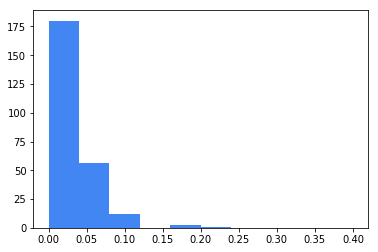

In [76]:
plt.hist(score_df_m[~score_df_m['adversary']]['average'], color='#4286f4', range=[0,0.4])

(array([   5.,  104.,  198.,  103.,   30.,    4.,    3.,    2.,    0.,    1.]),
 array([ 0.  ,  0.04,  0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,
         0.36,  0.4 ]),
 <a list of 10 Patch objects>)

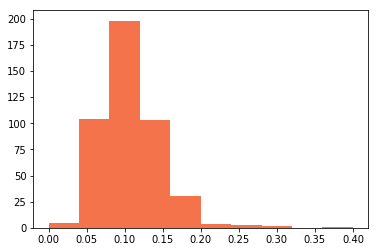

In [78]:
plt.hist(score_df_m[score_df_m['adversary']]['average'], color='#f4734b', range=[0,0.4])

In [60]:
true_mean = score_df_m[~score_df_m['adversary']]['average'].mean(axis=0)
true_std = score_df_m[~score_df_m['adversary']]['average'].std(axis=0)
fscoredf_m = []
for f in test_graphmls:
    col = {}
    col['adversary'] = False
    g = nx.read_graphml(join(GRAPH_LOC, f))
    for node in g.nodes():
        if node[len(node)-1] == '3':
            g.remove_node(node)
    j,score,scores = match(g.nodes(), tdf)
    ascore = np.mean(np.array(list(scores.values())))
    if ascore > true_mean + true_std:
        col['flagged'] = True
        col['flagged_amount'] = ascore - true_mean + true_std
    else:
        col['flagged'] = False
        col['flagged_amount'] = true_mean + true_std - ascore
    fscoredf_m.append(col)
for f in adv_graphmls:
    col = {}
    col['adversary'] = True
    g = nx.read_graphml(join(ADV_GRAPH_LOC, f))
    for node in g.nodes():
        if node[len(node)-1] == '3':
            g.remove_node(node)
    j,score,scores = match(g.nodes(), tdf)
    ascore = np.mean(np.array(list(scores.values())))
    if ascore > true_mean + true_std:
        col['flagged'] = True
        col['flagged_amount'] = ascore - true_mean + true_std
    else:
        col['flagged'] = False
        col['flagged_amount'] = true_mean + true_std - ascore
    fscoredf_m.append(col)
fscoredf_m = pd.DataFrame(fscoredf_m)

In [69]:
fscore(fscoredf_m)

('Number false positives: ', 61)
('Average FP Miss: ', 0.089772332217623832)
('Number false negatives: ', 37)
('Average FN Miss: ', 0.011074634542189623)
('Accuracy: ', 0.8909899888765295)
('f1_score: ', 0.8939393939393939)


{'accuracy': 0.8909899888765295,
 'false negatives': 37,
 'false positives': 61,
 'fscore': 0.8939393939393939}

In [97]:
score_df_max = []
for f in adv_graphmls:
    j,score,scores = rank_match(nx.read_graphml(join(ADV_GRAPH_LOC, f)).nodes(), tdf)
    scores['adversary'] = True
    scores['true'] = f[0]
    scores['predicted'] = f[2]
    score_df.append(scores)
for f in val_graphmls:
    j,score,scores = rank_match(nx.read_graphml(join(GRAPH_LOC, f)).nodes(), tdf)
    scores['adversary'] = False
    scores['true'] = f[0]
    scores['predicted'] = f[0]
    score_df.append(scores)
score_df = pd.DataFrame(score_df)
score_df.head()
score_df_max['max'] = score_df_max.drop(['adversary', 'predicted', 'true', 'average'], axis=1).idxmax(axis=1)

In [99]:
score_df_max['max'] = score_df_max['max'].apply(str)

In [100]:
score_df_max.head(10)

,0,1,2,3,4,5,6,7,8,9,adversary,predicted,true,average,max
0,38,29,22,26,30,15,15,35,29,27,True,2,0,26.6,0
1,35,23,16,36,44,29,61,19,49,37,True,7,6,34.9,6
2,12,9,24,36,39,24,25,18,34,41,True,0,9,26.2,9
3,26,20,20,47,42,42,15,40,42,29,True,4,3,32.3,3
4,37,14,35,30,34,23,17,53,33,32,True,2,7,30.8,7
5,27,16,42,47,28,25,11,47,26,56,True,0,7,32.5,9
6,24,82,34,36,29,54,33,29,58,42,True,8,1,42.1,1
7,24,25,12,15,12,19,15,18,32,16,True,0,1,18.8,8
8,18,22,24,44,23,18,17,19,55,42,True,3,5,28.2,8
9,60,35,21,26,37,21,41,24,48,26,True,4,2,33.9,0


In [105]:
print("Topological Classification Accuracy: ", float(score_df_max[score_df_max['true'] == score_df_max['max']].shape[0])/float(score_df_max.shape[0]))
print("Topological Classification Accuracy Adversary: ", float(score_df_max[(score_df_max['adversary']) & (score_df_max['true'] == score_df_max['max'])].shape[0])/float(score_df_max[score_df_max['adversary']].shape[0]))
print("Topological Classification Accuracy Unperturbed: ", float(score_df_max[(~score_df_max['adversary']) & (score_df_max['true'] == score_df_max['max'])].shape[0])/float(score_df_max[~score_df_max['adversary']].shape[0]))

('Topological Classification Accuracy: ', 0.3437945791726106)
('Topological Classification Accuracy Adversary: ', 0.30666666666666664)
('Topological Classification Accuracy Unperturbed: ', 0.4103585657370518)


0

In [109]:
fscoredf_max = []
for f in test_graphmls:
    col = {}
    col['adversary'] = False
    g = nx.read_graphml(join(GRAPH_LOC, f))
    for node in g.nodes():
        if node[len(node)-1] == '3':
            g.remove_node(node)
    j,score,scores = rank_match(g.nodes(), tdf)
    if f[0] != str(j):
        col['flagged'] = True
        col['flagged_amount'] = 0
    else:
        col['flagged'] = False
        col['flagged_amount'] = 0
    fscoredf_max.append(col)
for f in adv_graphmls:
    col = {}
    col['adversary'] = True
    g = nx.read_graphml(join(ADV_GRAPH_LOC, f))
    for node in g.nodes():
        if node[len(node)-1] == '3':
            g.remove_node(node)
    j,score,scores = rank_match(g.nodes(), tdf)
    if f[2] != str(j):
        col['flagged'] = True
        col['flagged_amount'] = 0
    else:
        col['flagged'] = False
        col['flagged_amount'] = 0
    fscoredf_max.append(col)
fscoredf_max = pd.DataFrame(fscoredf_max)

In [110]:
fscore(fscoredf_max)

('Number false positives: ', 238)
('Average FP Miss: ', 0.0)
('Number false negatives: ', 42)
('Average FN Miss: ', 0.0)
('Accuracy: ', 0.6885428253615128)
('f1_score: ', 0.7445255474452556)


{'accuracy': 0.6885428253615128,
 'false negatives': 42,
 'false positives': 238,
 'fscore': 0.7445255474452556}

In [111]:
maxdf = []
asims = []
for i in range(10):
    df = []
    print("Step {}".format(i))
    for f in graphmls + val_graphmls:
        if f[0] == str(i):
            col = {}
            g = nx.read_graphml(join(GRAPH_LOC, f))
            for node in g.nodes():
                if node[len(node)-1] == '3':
                    g.remove_node(node)
            df.append(g.nodes())
    df = pd.DataFrame(df, index=range(len(df))).transpose()
    
    print(df.shape)
    
    mdf = None
    r = list(df.columns)
    for perm in itertools.combinations(r, 2):
        if mdf is None:
            matchings = get_matchings(df[perm[0]].dropna(), df[perm[1]].dropna())
            mdf = pd.DataFrame(matchings)
        else:
            mdf = pd.concat([mdf, pd.Series(get_matchings(df[perm[0]].dropna(), df[perm[1]].dropna()))], ignore_index=True, axis=1)
#     mdf.columns = list(itertools.combinations(r,2))
    
    if mdf is not None:
        asims.append(average_sim(mdf))

        vcs = mdf.apply(pd.value_counts).fillna(0)
        maxdf.append(vcs.sum(axis=1).sort_values(ascending=False))

Step 0
(1016, 68)
Step 1
(260, 58)
Step 2
(647, 52)
Step 3
(141, 62)
Step 4
(962, 51)
Step 5
(264, 41)
Step 6
(237, 50)
Step 7
(756, 57)
Step 8
(855, 56)
Step 9
(249, 56)


In [112]:
fscoredf_max = []
for f in test_graphmls:
    col = {}
    col['adversary'] = False
    g = nx.read_graphml(join(GRAPH_LOC, f))
    for node in g.nodes():
        if node[len(node)-1] == '3':
            g.remove_node(node)
    j,score,scores = rank_match(g.nodes(), maxdf)
    if f[0] != str(j):
        col['flagged'] = True
        col['flagged_amount'] = 0
    else:
        col['flagged'] = False
        col['flagged_amount'] = 0
    fscoredf_max.append(col)
for f in adv_graphmls:
    col = {}
    col['adversary'] = True
    g = nx.read_graphml(join(ADV_GRAPH_LOC, f))
    for node in g.nodes():
        if node[len(node)-1] == '3':
            g.remove_node(node)
    j,score,scores = rank_match(g.nodes(), maxdf)
    if f[2] != str(j):
        col['flagged'] = True
        col['flagged_amount'] = 0
    else:
        col['flagged'] = False
        col['flagged_amount'] = 0
    fscoredf_max.append(col)
fscoredf_max = pd.DataFrame(fscoredf_max)

In [113]:
fscore(fscoredf_max)

('Number false positives: ', 235)
('Average FP Miss: ', 0.0)
('Number false negatives: ', 50)
('Average FN Miss: ', 0.0)
('Accuracy: ', 0.6829810901001112)
('f1_score: ', 0.7373271889400921)


{'accuracy': 0.6829810901001112,
 'false negatives': 50,
 'false positives': 235,
 'fscore': 0.7373271889400921}

In [114]:
mgs = []
for i in range(10):
    tg = nx.Graph()
    print("Step {}".format(i))
    for f in graphmls + val_graphmls:
        if f[0] == str(i):
            col = {}
            g = nx.read_graphml(join(GRAPH_LOC, f))
            for node in g.nodes():
                if node[len(node)-1] == '3':
                    g.remove_node(node)
            g = get_weighted_graph(g)
            for u,v,data in g.edges(data=True):
                if tg.has_edge(u,v):
                    tg[u][v]['weight'] += data['weight']
                    tg[u][v]['num'] += 1
                else:
                    tg.add_edge(u,v,attr_dict={'num':1}, weight=data['weight'])
    for u,v,data in tg.edges(data=True):
        tg[u][v]['weight'] = data['weight']/data['num']
    mgs.append(tg)

Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9


In [115]:
fscoredf_remax = []
for f in test_graphmls:
    col = {}
    col['adversary'] = False
    g = nx.read_graphml(join(GRAPH_LOC, f))
    bm,bs,s = edge_matching(g,mgs, how='rank')
    if str(bm) != f[0]:
        col['flagged'] = True
        col['flagged_amount'] = 0
    else:
        col['flagged'] = False
        col['flagged_amount'] = 0
    fscoredf_remax.append(col)
for f in adv_graphmls:
    col = {}
    col['adversary'] = True
    g = nx.read_graphml(join(ADV_GRAPH_LOC, f))
    bm,bs,s = edge_matching(g,mgs, how='rank')
    if str(bm) != f[2]:
        col['flagged'] = True
        col['flagged_amount'] = 0
    else:
        col['flagged'] = False
        col['flagged_amount'] = 0
    fscoredf_remax.append(col)
fscoredf_remax = pd.DataFrame(fscoredf_remax)
fscoredf_remax.head()

,adversary,flagged,flagged_amount
0,False,False,0
1,False,False,0
2,False,True,0
3,False,False,0
4,False,True,0


In [116]:
fscore(fscoredf_remax)

('Number false positives: ', 326)
('Average FP Miss: ', 0.0)
('Number false negatives: ', 42)
('Average FN Miss: ', 0.0)
('Accuracy: ', 0.5906562847608454)
('f1_score: ', 0.6891891891891893)


{'accuracy': 0.5906562847608454,
 'false negatives': 42,
 'false positives': 326,
 'fscore': 0.6891891891891893}